In [44]:
import argparse
import traceback

import pandas as pd
import numpy as np
from scipy import interpolate

from sklearn import metrics
from sklearn import datasets
from sklearn.model_selection import train_test_split as ts
from sklearn.metrics import roc_curve,auc,roc_auc_score,precision_recall_curve

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.autograd import Variable

from plotnine import *
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")


torch.cuda.empty_cache()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device=",device)

black = '#222222'
gray = '#666666'
red = '#FF3333'
green = '#66CC00'
blue = '#3333FF'
purple = '#9933FF'
orange = '#FF8000'
yellow = '#FFFF33'



class Config:

    train_dir="m5C/feature/train/"
    test_dir="ELIGOS_C/feature/test/"
    #train_dir = "data/motif/CTCAC/train/"
    #test_dir = "data/motif/CTCAC/test/"
    batch_size = 500
    learning_rate=0.00001
    
    
kmer_encode_dic={'A': 0, "C": 1, "G": 2, "T": 3}  
kmer_decode_dict ={0:"A", 1:"C", 2:"G", 3:"T"}

class BahdanauAttention(nn.Module):
    """
    Bahdanau Attention mechanism module.

    Args:
        in_features (int): Number of input features.
        hidden_units (int): Number of hidden units.
        num_task (int): Number of tasks.
    """
    def __init__(self,in_features, hidden_units,num_task):
        super(BahdanauAttention,self).__init__()
        self.W1 = nn.Linear(in_features=in_features,out_features=hidden_units)
        self.W2 = nn.Linear(in_features=in_features,out_features=hidden_units)
        self.V = nn.Linear(in_features=hidden_units, out_features=num_task)

    def forward(self, hidden_states, values):
        hidden_with_time_axis = torch.unsqueeze(hidden_states,dim=1)

        score  = self.V(nn.Tanh()(self.W1(values)+self.W2(hidden_with_time_axis)))
        attention_weights = nn.Softmax(dim=1)(score)
        values = torch.transpose(values,1,2)   # transpose to make it suitable for matrix multiplication
        #print(attention_weights.shape,values.shape)
        context_vector = torch.matmul(values,attention_weights)
        context_vector = torch.transpose(context_vector,1,2)
        return context_vector, attention_weights

class TandemMod(nn.Module):
    def __init__(self,num_classes=2,vocab_zie=5, embedding_size=4,seq_len=5):
        super(TandemMod,self).__init__()

        self.seq_len=seq_len
        self.embed = nn.Embedding(vocab_zie, embedding_size)

        self.cnn_1d = nn.Sequential(
            nn.Conv1d(in_channels=1,out_channels=64,kernel_size=7,stride=2,padding=0),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Conv1d(in_channels=64,out_channels=128,kernel_size=3,stride=1,padding=0),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2,padding=1),
            nn.Dropout(p=0.2),
            nn.Conv1d(in_channels=128,out_channels=128,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2,padding=1),

        )
        self.lstm=nn.LSTM(input_size=128,hidden_size=128,batch_first=True,bidirectional=True)
        self.attention=BahdanauAttention(in_features=256,hidden_units=10,num_task=1)
        self.fc = nn.Sequential(
            nn.Linear(in_features=1536,out_features=1536),
            nn.ReLU(),
            nn.Linear(in_features=1536, out_features=1024),
            nn.ReLU(),
            nn.Linear(in_features=1024, out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512,out_features=2)
        )

        self.lstm_seq=nn.LSTM(input_size=4+5,hidden_size=128,batch_first=True,bidirectional=True)   #embedding_size+feature_num


    def seq_to_digit(self,seq):
        return torch.Tensor([{'A': 0, "C": 1, "G": 2, "T": 3}[i] for i in list(seq)]).long()


    def forward(self,x,kmer,mean,std,intense,dwell,base_quality):
        kmer_embedded=self.embed(kmer)
        mean = torch.reshape(mean, (-1, self.seq_len, 1)).float()
        std = torch.reshape(std, (-1, self.seq_len, 1)).float()
        intense = torch.reshape(intense, (-1, self.seq_len, 1)).float()
        dwell = torch.reshape(dwell, (-1, self.seq_len, 1)).float()
        base_quality = torch.reshape(base_quality, (-1, self.seq_len, 1)).float()
        
        out_seq=torch.cat((kmer_embedded,mean,std,intense,dwell,base_quality),2)


        out_seq,(h_n_seq,c_n_seq)=self.lstm_seq(out_seq)

        x = self.cnn_1d(x)

        batch_size, features, seq_len = x.size()
        x = x.view(batch_size, seq_len, features)  # parepare input for LSTM

        output, (h_n, c_n) = self.lstm(x)

        h_n = h_n.view(batch_size, output.size()[-1])  # pareprae input for Attention
        context_vector, attention_weights = self.attention(h_n, output)  # Attention (batch_size, num_task, unit)


        out=torch.cat((out_seq[:,0,:],out_seq[:,1,:],out_seq[:,2,:],out_seq[:,3,:],out_seq[:,4,:],context_vector[:,0,:]),1)
        #out=context_vector[:,0,:]
        out.view(out.size()[0],1,out.size()[1])
        x=self.fc(out)
        #x.view(x.size()[0], 1, x.size()[1])
        return x


class NN(TandemMod):
    def __init__(self):
        """
        Initialize the NN class.
        Inherits from the TandemMod class.
        """
        super(NN, self).__init__()

################median mad####################################################    
x_test_median_mad,y_test_median_mad=[],[]
f=open("/home/wuyou/Projects/paper/ELIGOS_normalC/feature/median_mad/ELIGOS_normalC")
for i,line in enumerate(f):
    if i>4e5:
        break
    line=line.rstrip()
    items=line.split("\t")

    signals="|".join(items[9:14]).split("|")
    signal=np.array([float(signal) for signal in signals])
    #signal=(signal-np.mean(signal))/np.std(signal)
    kmer = items[3]
    kmer=np.array([kmer_encode_dic[base] for base in kmer])
    mean = np.array([float(item) for item in items[4].split("|")])
    std = np.array([float(item) for item in items[5].split("|")])
    intense = np.array([float(item) for item in items[6].split("|")])
    dwell = np.array([float(item) for item in items[7].split("|")])/200
    base_quality = np.array([float(item) for item in items[8].split("|")])/40
    x=[signal, kmer, mean, std, intense, dwell,base_quality]
    x_test_median_mad.append(x)
    y_test_median_mad.append(0)
f.close()

f=open("/home/wuyou/Projects/paper/ELIGOS_m5C/feature/median_mad/ELIGOS_m5C")
for i,line in enumerate(f):
    if i>4e5:
        break
    line=line.rstrip()
    items=line.split("\t")

    signals="|".join(items[9:14]).split("|")
    signal=np.array([float(signal) for signal in signals])
    #signal=(signal-np.mean(signal))/np.std(signal)
    kmer = items[3]
    kmer=np.array([kmer_encode_dic[base] for base in kmer])
    mean = np.array([float(item) for item in items[4].split("|")])
    std = np.array([float(item) for item in items[5].split("|")])
    intense = np.array([float(item) for item in items[6].split("|")])
    dwell = np.array([float(item) for item in items[7].split("|")])/200
    base_quality = np.array([float(item) for item in items[8].split("|")])/40
    x=[signal, kmer, mean, std, intense, dwell,base_quality]
    x_test_median_mad.append(x)
    y_test_median_mad.append(1)
f.close()



class MyDataset(Dataset):
    """
    Custom dataset class.

    Args:
        x (list or numpy array): Input data.
        y (list or numpy array): Target data.

    """
    def __init__(self,x,y):
        self.x=x
        self.y=y

    def __getitem__(self, index):
        return self.x[index],self.y[index]

    def __len__(self):
        return len(self.x)


def make_weights_for_balanced_classes(images, nclasses):
    """
    Computes weights for balancing classes in a dataset.

    Args:
        images (list): List of images.
        nclasses (int): Number of classes.

    Returns:
        list: List of weights.

    """
    count = [0] * nclasses
    for item in images:
        count[item[1]] += 1
    weight_per_class = [0.] * nclasses
    N = float(sum(count))
    for i in range(nclasses):
        weight_per_class[i] = N/float(count[i])
    weight = [0] * len(images)
    for idx, val in enumerate(images):
        weight[idx] = weight_per_class[val[1]]
    return weight


from torch.utils.data import WeightedRandomSampler
class CustomWeightedRandomSampler(WeightedRandomSampler):
    """
    Custom implementation of WeightedRandomSampler.
    WeightedRandomSampler except allows for more than 2^24 samples to be sampled
    Args:
        *args: Variable length argument list.
        **kwargs: Arbitrary keyword arguments.

    """
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def __iter__(self):
        rand_tensor = np.random.choice(range(0, len(self.weights)),
                                       size=self.num_samples,
                                       p=self.weights.numpy() / torch.sum(self.weights).numpy(),
                                       replace=self.replacement)
        rand_tensor = torch.from_numpy(rand_tensor)
        return iter(rand_tensor.tolist())

print("loading data...")

model = TandemMod(num_classes=2,vocab_zie=5, embedding_size=4,seq_len=5).to(device)
optimizer = torch.optim.Adam(model.parameters(),lr = 0.001)

loss_func = torch.nn.CrossEntropyLoss()#.to(device)
#predict_result=open("rice/results/WT_precit_results.tsv","w")

def predict(model,dataset,cut_off_threshold):
    """
    Predicts the output of the model on the given dataset.

    Parameters:
        model (nn.Module): The trained model to use for prediction.
        dataset (torch.utils.data.Dataset): The dataset to predict on.

    Returns:
        fpr (array): False positive rates.
        tpr (array): True positive rates.
        precision (array): Precision values.
        recall (array): Recall values.
        roc_auc (float): Area under the ROC curve.
        pr_auc (float): Area under the precision-recall curve.
    """

    dataloader=torch.utils.data.DataLoader(dataset=dataset, 
                                           batch_size=2000, 
                                           shuffle=True,
                                           num_workers=36,
                                           pin_memory=True)

    try:

        test_acc = 0.
        y_test = []
        y_pred = []
        label_dict={0:"m5C",1:"C"}

        for i,(batch_x, batch_y) in enumerate(dataloader):

            signal, kmer, mean, std, intense, dwell,base_quality = batch_x
            signal= Variable(signal.to(device)).to(torch.float32)

            kmer = Variable(kmer.to(device)).to(torch.long)
            mean = Variable(mean.to(device)).to(torch.float32)
            std = Variable(std.to(device)).to(torch.float32)
            intense = Variable(intense.to(device)).to(torch.float32)
            dwell = Variable(dwell.to(device)).to(torch.float32)
            base_quality = Variable(base_quality.to(device)).to(torch.float32)
            batch_size, features = signal.size()
            signal = signal.view(batch_size, 1, features)

            out = model(signal, kmer, mean, std, intense, dwell,base_quality )
            batch_size, out_channels = out.size()

            out = out.view(batch_size, out_channels)
            pred = torch.max(out, 1)[1].numpy()

            out=torch.softmax(out,dim=1)
            probabilities=out.detach().numpy()[:,1]
            batch_y=batch_y.detach().numpy()
            #print(probabilities)
            
            
            selected_batch_y=[]
            selected_probabilities=[]
            for j in range(len(batch_y)):
                if probabilities[j]<cut_off_threshold[0] or probabilities[j]>cut_off_threshold[1]:
                    selected_batch_y.append(batch_y[j])
                    selected_probabilities.append(probabilities[j])
            
            print("Probability cutoff:",cut_off_threshold[0],cut_off_threshold[1],"\tPreserved sites:",len(selected_batch_y))
            fpr,tpr,thersholds=roc_curve(selected_batch_y,selected_probabilities)
            precision,recall,thersholds=precision_recall_curve(selected_batch_y,selected_probabilities)
            
            roc_auc=auc(fpr,tpr)
            pr_auc=auc(recall,precision)
            
            return fpr,tpr,precision,recall,roc_auc,pr_auc,len(selected_batch_y)/len(batch_y),probabilities,batch_y
            
    except Exception as e:
        print(e)
        traceback.print_exc()



def decode(t):
    motifs=[]
    for item in t:
        motifs.append("".join([kmer_decode_dict[base] for base in item]))
    return motifs


def predict_motif(model,dataset,cut_off_threshold):
    """
    Predicts the output of the model on the given dataset.

    Parameters:
        model (nn.Module): The trained model to use for prediction.
        dataset (torch.utils.data.Dataset): The dataset to predict on.

    Returns:
        fpr (array): False positive rates.
        tpr (array): True positive rates.
        precision (array): Precision values.
        recall (array): Recall values.
        roc_auc (float): Area under the ROC curve.
        pr_auc (float): Area under the precision-recall curve.
    """

    dataloader=torch.utils.data.DataLoader(dataset=dataset, 
                                           batch_size=2000, 
                                           shuffle=True,
                                           num_workers=36,
                                           pin_memory=True)

    try:

        test_acc = 0.
        y_test = []
        y_pred = []
        label_dict={0:"m5C",1:"C"}
        labels=[]
        motifs=[]
        P=[]
        for i,(batch_x, batch_y) in enumerate(dataloader):

            signal, kmer, mean, std, intense, dwell,base_quality = batch_x
            signal= Variable(signal.to(device)).to(torch.float32)

            kmer = Variable(kmer.to(device)).to(torch.long)
            mean = Variable(mean.to(device)).to(torch.float32)
            std = Variable(std.to(device)).to(torch.float32)
            intense = Variable(intense.to(device)).to(torch.float32)
            dwell = Variable(dwell.to(device)).to(torch.float32)
            base_quality = Variable(base_quality.to(device)).to(torch.float32)
            batch_size, features = signal.size()
            signal = signal.view(batch_size, 1, features)

            out = model(signal, kmer, mean, std, intense, dwell,base_quality )
            batch_size, out_channels = out.size()

            out = out.view(batch_size, out_channels)
            pred = torch.max(out, 1)[1].numpy()

            out=torch.softmax(out,dim=1)
            probabilities=out.detach().numpy()[:,1]
            batch_y=batch_y.detach().numpy()
            #print(probabilities)
            
            
            selected_batch_y=[]
            selected_probabilities=[]
            for j in range(len(batch_y)):
                if probabilities[j]<cut_off_threshold[0] or probabilities[j]>cut_off_threshold[1]:
                    selected_batch_y.append(batch_y[j])
                    selected_probabilities.append(probabilities[j])
            
            print("Probability cutoff:",cut_off_threshold[0],cut_off_threshold[1],"\tPreserved sites:",len(selected_batch_y))
            fpr,tpr,thersholds=roc_curve(selected_batch_y,selected_probabilities)
            precision,recall,thersholds=precision_recall_curve(selected_batch_y,selected_probabilities)
            
            roc_auc=auc(fpr,tpr)
            pr_auc=auc(recall,precision)
            
            P.extend(list(probabilities))
            labels.extend(list(batch_y))




            #print(432,decode(kmer.numpy()))
            motifs.extend(decode(kmer.numpy()))

        return P,labels,motifs
            
    except Exception as e:
        print(e)
        traceback.print_exc()
        
if __name__ == "__main__":
    #parser = argparse.ArgumentParser(description='Extract feature from signal.')
    #parser.add_argument('-feature', default='BaseCalled_template',help='Basecall subgroup Nanoraw resquiggle into. Default is BaseCalled_template')
    #args = parser.parse_args()
  
    
    fprs,tprs,precisions,recalls,normalization_roc,normalization_pr,preserved_ratio_list=[],[],[],[],[],[],[]
    
    dataset=MyDataset(x_test_median_mad,y_test_median_mad)

    print("predicting...")
    
    model= torch.load('/home/wuyou/Projects/paper/model/m5C_median_mad.pkl')
    fpr,tpr,precision,recall,roc_auc_MMAD,pr_auc_MMAD,preserved_ratio,probabilities,_=predict(model,dataset,[0.5,0.5])
    fprs.extend(fpr)
    tprs.extend(tpr)
    precisions.extend(precision)
    recalls.extend(recall)
    preserved_ratio_list.append(preserved_ratio)
    normalization_roc.extend(["0.5 0.5 AUC %.2f" %roc_auc_MMAD]*len(fpr))
    normalization_pr.extend(["0.5 0.5 AUC %.2f" %pr_auc_MMAD]*len(precision))
    
    
    fpr,tpr,precision,recall,roc_auc_MMAD,pr_auc_MMAD,preserved_ratio,probabilities,_=predict(model,dataset,[0.4,0.6])
    fprs.extend(fpr)
    tprs.extend(tpr)
    precisions.extend(precision)
    recalls.extend(recall)
    preserved_ratio_list.append(preserved_ratio)
    normalization_roc.extend(["0.4 0.6 AUC %.2f" %roc_auc_MMAD]*len(fpr))
    normalization_pr.extend(["0.4 0.6 AUC %.2f" %pr_auc_MMAD]*len(precision))
    
    fpr,tpr,precision,recall,roc_auc_MMAD,pr_auc_MMA,preserved_ratio,probabilities,_=predict(model,dataset,[0.3,0.7])
    fprs.extend(fpr)
    tprs.extend(tpr)
    precisions.extend(precision)
    recalls.extend(recall)
    preserved_ratio_list.append(preserved_ratio)
    normalization_roc.extend(["0.3 0.7 AUC %.2f" %roc_auc_MMAD]*len(fpr))
    normalization_pr.extend(["0.3 0.7 AUC %.2f" %pr_auc_MMAD]*len(precision))
    
    fpr,tpr,precision,recall,roc_auc_MMAD,pr_auc_MMAD,preserved_ratio,probabilities,_=predict(model,dataset,[0.2,0.8])
    fprs.extend(fpr)
    tprs.extend(tpr)
    precisions.extend(precision)
    recalls.extend(recall)
    preserved_ratio_list.append(preserved_ratio)
    normalization_roc.extend(["0.2 0.8 AUC %.2f" %roc_auc_MMAD]*len(fpr))
    normalization_pr.extend(["0.2 0.8 AUC %.2f" %pr_auc_MMAD]*len(precision))
    
    fpr,tpr,precision,recall,roc_auc_MMAD,pr_auc_MMAD,preserved_ratio,probabilities,_=predict(model,dataset,[0.1,0.9])
    fprs.extend(fpr)
    tprs.extend(tpr)
    precisions.extend(precision)
    recalls.extend(recall)
    preserved_ratio_list.append(preserved_ratio)
    normalization_roc.extend(["0.1 0.9 AUC %.2f" %roc_auc_MMAD]*len(fpr))
    normalization_pr.extend(["0.1 0.9 AUC %.2f" %pr_auc_MMAD]*len(precision))

device= cpu
loading data...
predicting...
Probability cutoff: 0.5 0.5 	Preserved sites: 2000
Probability cutoff: 0.4 0.6 	Preserved sites: 1928
Probability cutoff: 0.3 0.7 	Preserved sites: 1834
Probability cutoff: 0.2 0.8 	Preserved sites: 1725
Probability cutoff: 0.1 0.9 	Preserved sites: 1559


Probability cutoff: 0.5 0.5 	Preserved sites: 2000
Probability cutoff: 0.5 0.5 	Preserved sites: 2000
Probability cutoff: 0.5 0.5 	Preserved sites: 2000
Probability cutoff: 0.5 0.5 	Preserved sites: 2000
Probability cutoff: 0.5 0.5 	Preserved sites: 2000
Probability cutoff: 0.5 0.5 	Preserved sites: 2000
Probability cutoff: 0.5 0.5 	Preserved sites: 2000
Probability cutoff: 0.5 0.5 	Preserved sites: 2000
Probability cutoff: 0.5 0.5 	Preserved sites: 2000
Probability cutoff: 0.5 0.5 	Preserved sites: 2000
Probability cutoff: 0.5 0.5 	Preserved sites: 2000
Probability cutoff: 0.5 0.5 	Preserved sites: 2000
Probability cutoff: 0.5 0.5 	Preserved sites: 2000
Probability cutoff: 0.5 0.5 	Preserved sites: 2000
Probability cutoff: 0.5 0.5 	Preserved sites: 2000
Probability cutoff: 0.5 0.5 	Preserved sites: 2000
Probability cutoff: 0.5 0.5 	Preserved sites: 2000
Probability cutoff: 0.5 0.5 	Preserved sites: 2000
Probability cutoff: 0.5 0.5 	Preserved sites: 2000
Probability cutoff: 0.5 0.5 	Pr

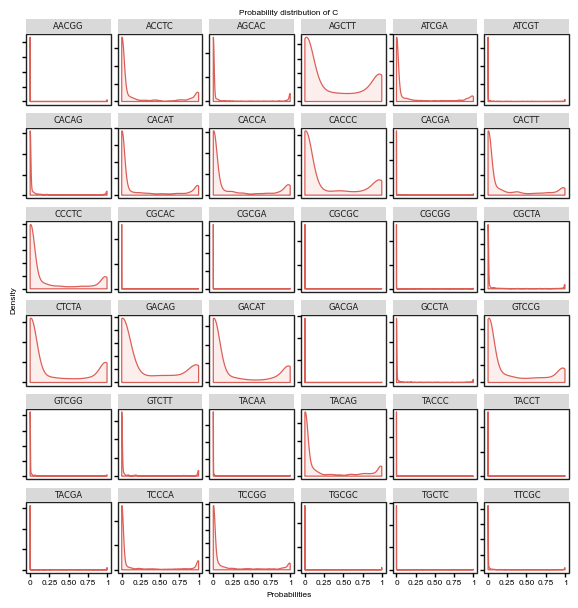


        Probabilities  label motifs
6        2.085318e-03      0  CACAG
7        9.998716e-01      1  TACCC
12       6.938332e-03      0  GTCCG
17       1.000000e+00      1  AACGG
21       1.458262e-10      0  TACCC
...               ...    ...    ...
799943   1.000000e+00      0  TCCCA
799948   8.658408e-04      0  CACAT
799957   9.998412e-01      1  CTCTA
799974   1.374061e-05      0  CGCTA
799998   9.999992e-01      1  CGCGA

[114077 rows x 3 columns]


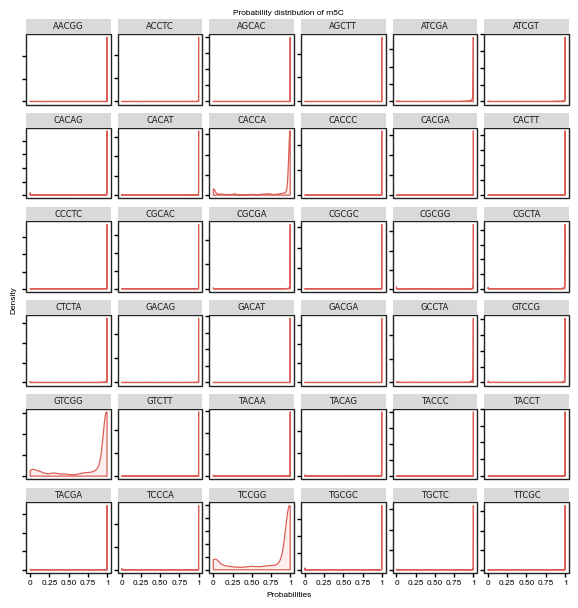

In [46]:
#model= torch.load('/home/wuyou/Projects/paper/model/m5C_median_mad.pkl')
from plotnine import *
import plotnine as p9

model= torch.load('/home/wuyou/Projects/paper/model/m5C_Os_AD_median_mad.pkl')
#model= torch.load('/home/wuyou/Projects/paper/model/m5C_Os_AD_median_mad_2.22_overlap.pkl')
P,labels,motifs=predict_motif(model,dataset,[0.5,0.5])
#fpr,tpr,precision,recall,roc_auc_MMAD,pr_auc_MMAD,preserved_ratio,probabilities,labels=predict(model,dataset,[0.5,0.5])

data=pd.DataFrame(dict(Probabilities=P,label=labels,motifs=motifs)) 

import itertools

# Define the nucleotides
nucleotides = ['A', 'T', 'G', 'C']

# Use itertools.product to generate all combinations of 4 nucleotides (2 before and 2 after 'C')
combinations = itertools.product(nucleotides, repeat=4)

# Construct the 5-mer motifs with 'C' in the middle
all_motifs = [''.join([a, b, 'C', c, d]) for a, b, c, d in combinations]

import random

# Set a random seed for reproducibility
random.seed(0)  # You can choose any number as the seed

# Total number of items and number of items to select
total_items = 256  # Range from 0 to 255
items_to_select = 36  # Number of items to select

# Create a list of numbers from 0 to 255


# Randomly select 25 unique items from the list
selected_motifs= random.sample(all_motifs, items_to_select)

# Print the selected items
print(selected_motifs)



data=data[data["motifs"].str.contains("|".join(selected_motifs))]
#data=data[data["motifs"] == "AACAA"]


data_C=data[data["label"]==0]
print(data)
#data.to_csv("data/density_of_reads_probablilities_m5C_on_ELIGOS.csv")
p1 = (ggplot()
        #+geom_bar(data,aes(x="Probabilities",y = "Proportion"),stat="identity",width=0.6)
        +geom_density(data_C,aes(x="Probabilities",fill="black",color="black"),alpha=0.1,show_legend=False)
        +theme(panel_background=element_rect(fill=gray, alpha=0),
            panel_grid_major=element_line(size=0.3, alpha=0,color=black),
            panel_grid_minor=element_line(size=0.3, alpha=0,color=black),
            panel_border=element_rect(color=black, size=1),
            axis_text=element_text(size=6,family="Arial",color="black"),
            axis_title_x=element_text(size=6,family="Arial",color="black"),
            axis_title_y=element_text(size=6,family="Arial",color="black"),
            axis_text_y=p9.element_blank(),
            plot_title=element_text(margin={'b': 1, 'r': 0, 'units': 'pt'},size=6,family="Arial",color="black",hjust=0.5),
            strip_text=p9.element_text(size=6),   #facet font size
            #axis_text_x=element_text(rotation=45, hjust=0.5),
            figure_size=[7,7],
            #legend_title = element_text(size=6), #change legend title font size
            #legend_text = element_text(size=6),
            #legend_background=element_rect(size=0.5,alpha=0),
            legend_position=(0.60,0.4),
            #legend_key_size=4   #change legend text font size
              ) 
        +labs(x = "Probabilities", y ="Density")
        #guides(color = guide_legend(title = "Probability cutoff"))
      +facet_wrap('motifs',scales='free_y')
      +ggtitle("Probability distribution of C")

)
print(p1)
p1.save("figure/figure_2e_probabilities_distribution_of_C_on_ELIGOS_36motifs.pdf")

data_m5C=data[data["label"]==1]
print(data)
#data.to_csv("data/density_of_reads_probablilities_m5C_on_ELIGOS.csv")
p1 = (ggplot()
        #+geom_bar(data,aes(x="Probabilities",y = "Proportion"),stat="identity",width=0.6)
        +geom_density(data_m5C,aes(x="Probabilities",fill="black",color="black"),alpha=0.1,show_legend=False)
        +theme(panel_background=element_rect(fill=gray, alpha=0),
            panel_grid_major=element_line(size=0.3, alpha=0,color=black),
            panel_grid_minor=element_line(size=0.3, alpha=0,color=black),
            panel_border=element_rect(color=black, size=1),
            axis_text=element_text(size=6,family="Arial",color="black"),
            axis_title_x=element_text(size=6,family="Arial",color="black"),
            axis_title_y=element_text(size=6,family="Arial",color="black"),
            axis_text_y=p9.element_blank(),
            plot_title=element_text(margin={'b': 1, 'r': 0, 'units': 'pt'},size=6,family="Arial",color="black",hjust=0.5),
            strip_text=p9.element_text(size=6),   #facet font size
            #axis_text_x=element_text(rotation=45, hjust=0.5),
            figure_size=[7,7],
            #legend_title = element_text(size=6), #change legend title font size
            #legend_text = element_text(size=6),
            #legend_background=element_rect(size=0.5,alpha=0),
            legend_position=(0.60,0.4),
            #legend_key_size=4   #change legend text font size
              ) 
        +labs(x = "Probabilities", y ="Density")
        #guides(color = guide_legend(title = "Probability cutoff"))
      +ggtitle("Probability distribution of m5C")
      +facet_wrap('motifs',scales='free_y')
)
print(p1)
p1.save("figure/figure_2e_probabilities_distribution_of_m5C_on_ELIGOS_36motifs.pdf")

In [48]:
data=pd.DataFrame(dict(Probabilities=P,label=labels,motifs=motifs)) 
data.head()

,Probabilities,label,motifs
0,0.032028,1,CCCAG
1,0.994741,0,AACCG
2,1.000000,1,AGCGG
3,0.006037,0,TACTC
4,0.000001,0,GGCCG


In [55]:
#analyse discarded reads

discard_motif_dict={}

for  i in range(len(data)):
    motif=data.iloc[i]["motifs"]
    label=data.iloc[i]["label"]
    probability=data.iloc[i]["Probabilities"]

    if motif not in discard_motif_dict:
        discard_motif_dict[motif]=[0,0]

    if label==0:
        if probability>0.3:
            discard_motif_dict[motif][0]+=1
        discard_motif_dict[motif][1]+=1
    
    if label==1:
        if probability<0.7:
            discard_motif_dict[motif][0]+=1
        discard_motif_dict[motif][1]+=1


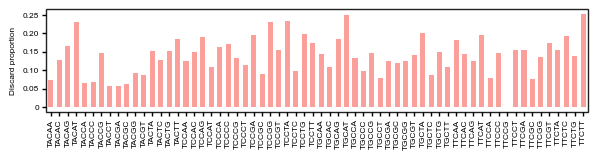

: 

In [79]:
discard_motif_dict

motif_list=[]
proportion_list=[]
first_base=[]

for motif in discard_motif_dict:

    first_base.append(motif[0])
    motif_list.append(motif)
    proportion_list.append(discard_motif_dict[motif][0]/discard_motif_dict[motif][1])

black = '#222222'
gray = '#666666'
red = '#FF3333'
green = '#66CC00'
blue = '#3333FF'
purple = '#9933FF'
orange = '#FF8000'
yellow = '#FFFF33'

c1="#F8766D"
c2="#00BA38"
c3="#619CFF"

plot_data=pd.DataFrame(dict(motif=motif_list,proportion=proportion_list,first_base=first_base))

plot_data_A=plot_data[plot_data["first_base"]=="T"]

p1 = (ggplot()
        +geom_bar(plot_data_A,aes(x="motif",y = "proportion"),fill=c1,stat="identity",width=0.6,alpha=0.7)
        
        +theme(panel_background=element_rect(fill=gray, alpha=0),
            panel_grid_major=element_line(size=0.3, alpha=0,color=black),
            panel_grid_minor=element_line(size=0.3, alpha=0,color=black),
            panel_border=element_rect(color=black, size=1),
            axis_text=element_text(size=6,family="Arial",color="black"),
            axis_text_x=element_text(size=6,family="Arial",color="black",angle=90),
            axis_title_x=element_text(size=6,family="Arial",color="black"),
            axis_title_y=element_text(size=6,family="Arial",color="black"),
            
            #axis_text_x=element_text(rotation=45, hjust=0.5),
            figure_size=[7,1.33],
            legend_title = element_text(size=6), #change legend title font size
            legend_text = element_text(size=6),
            legend_background=element_rect(size=0.5,alpha=0),
            #legend_position=(0.60,0.4),
               
            plot_title=element_text(margin={'b': 1, 'r': 0, 'units': 'pt'},size=6,family="Arial",color="black"),
            
            legend_position=None,
            legend_key_size=4) #change legend text font size
        +labs(x = "", y ="Discard proportion")
        #+guides(color = guide_legend(title = "Probability cutoff"))
        #+ ggtitle("Curlcake")
        +scale_fill_manual([c1])
    )
print(p1)
p1.save('figure/figure_2e_discard_proportion_T.pdf')

In [61]:
plot_data

,motif,proportion
0,CCCAG,0.207490
1,AACCG,0.151419
2,AGCGG,0.175554
3,TACTC,0.128001
4,GGCCG,0.175463
...,...,...
251,TTCAG,0.124852
252,ATCTG,0.313578
253,CACCG,0.207246
254,CCCGC,0.188845
